In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
from house.iec import find_similar_days, mins_in_day, baseline_similarity, lerp, calc_baseline, gauss_filt

In [3]:
dataset_filename = 'dataset.gz'
dataset_tz = 'Europe/Zurich'

dataset = pd.read_csv(dataset_filename, parse_dates=[0], index_col=0).tz_localize('UTC').tz_convert(dataset_tz)

In [4]:
data= dataset.copy()

In [5]:
TrainingWindow=24 * 60 * 60
PredictionWindow = timedelta(minutes=12 * 60)
now = data.index[-1]
K = 5
cons_col = 'House Consumption'
TrainingData = data.tail(TrainingWindow)

In [6]:
ObservationLength = mins_in_day(now) + (4 * 60)

In [7]:
KSimilarDays = find_similar_days(
            TrainingData, ObservationLength, K, 15, method=baseline_similarity)

In [8]:
TrainingData = TrainingData[[cons_col]]
a = KSimilarDays[0]

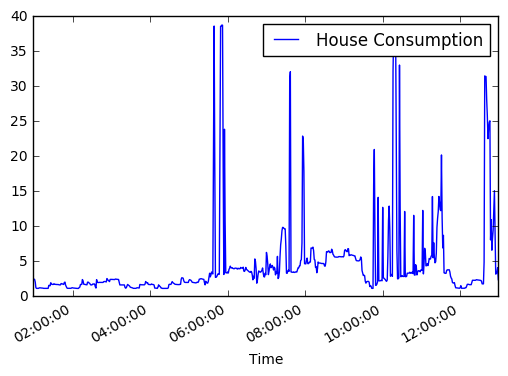

In [9]:
TrainingData[a:a+PredictionWindow].plot()

In [10]:
index = pd.DatetimeIndex(start=now, freq='T', end=now+PredictionWindow)
prediction = pd.DataFrame(index=index)

In [11]:
r = np.zeros((721,1))
for i in KSimilarDays:
    r += (1/K)*TrainingData[i:i+PredictionWindow].rolling(window = 100, center=True, min_periods=1).mean().as_matrix()
baseline = np.squeeze(r)

In [12]:
prediction['Prediction'] = r

In [18]:
recent_baseline = TrainingData[-2*60:-1].mean()[cons_col]

In [19]:
interp_range = 200
baseline[:interp_range] = lerp(np.repeat(recent_baseline, interp_range),
                                   baseline[:interp_range],
                                   np.arange(interp_range)/interp_range)

In [16]:
baseline = calc_baseline(
            TrainingData, KSimilarDays, PredictionWindow, 60, method=gauss_filt)

3.475011655
